<a href="https://colab.research.google.com/github/guangyitan/face-mask-detector/blob/main/Video_Input_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [3]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
# def detect_and_predict_mask(frame,faceNet,maskNet):
#     #grab the dimensions of the frame and then construct a blob
#     (h,w)=frame.shape[:2]
#     blob=cv2.dnn.blobFromImage(frame,1.0,(300,300),(104.0,177.0,123.0))
    
#     faceNet.setInput(blob)
#     detections=faceNet.forward()
    
#     #initialize our list of faces, their corresponding locations and list of predictions
    
#     faces=[]
#     locs=[]
#     preds=[]
    
    
#     for i in range(0,detections.shape[2]):
#         confidence=detections[0,0,i,2]
    
    
#         if confidence>0.5:
#         #we need the X,Y coordinates
#             box=detections[0,0,i,3:7]*np.array([w,h,w,h])
#             (startX,startY,endX,endY)=box.astype('int')
        
#             #ensure the bounding boxes fall within the dimensions of the frame
#             (startX,startY)=(max(0,startX),max(0,startY))
#             (endX,endY)=(min(w-1,endX), min(h-1,endY))
        
#             #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
#             face=frame[startY:endY, startX:endX]
#             face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
#             face=cv2.resize(face,(224,224))
#             face=img_to_array(face)
#             face=preprocess_input(face)
        
#             faces.append(face)
#             locs.append((startX,startY,endX,endY))
        
#         #only make a predictions if atleast one face was detected
#         if len(faces)>0:
#             faces=np.array(faces,dtype='float32')
#             preds=maskNet.predict(faces,batch_size=12)
        
#         return (locs,preds)

In [4]:
# declare the project path
project_path = '/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/'

# declare the model and weights parh of caffe model
prototxtPath = project_path + 'Res/deploy.prototxt'
weightsPath = project_path + 'Res/res10_300x300_ssd_iter_140000.caffemodel'

print(prototxtPath)
print(weightsPath)

/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/Res/deploy.prototxt
/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/Res/res10_300x300_ssd_iter_140000.caffemodel


In [5]:
faceNet=cv2.dnn.readNet(prototxtPath,weightsPath)

In [6]:
# load our mask classifying model
model = load_model('/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/Saved_model')

In [7]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

<IPython.core.display.Javascript object>

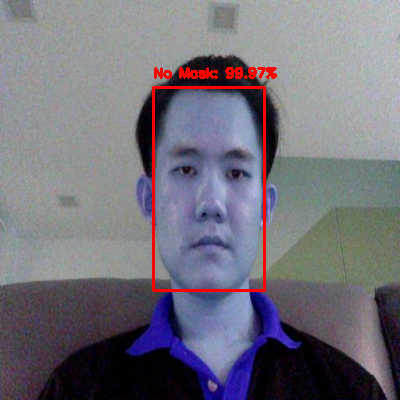

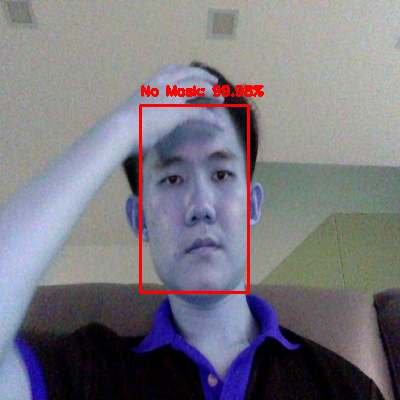

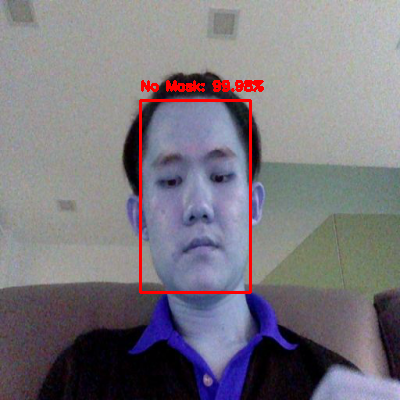

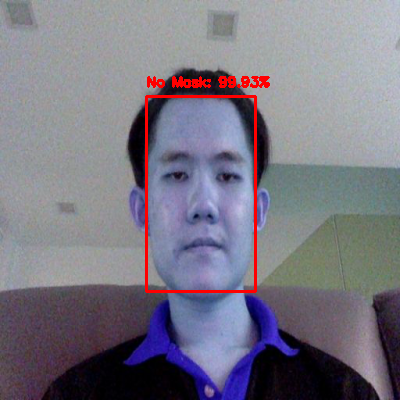

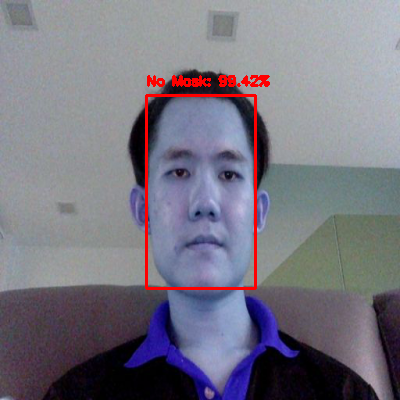

In [9]:
import imutils
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)

	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
  frame = image
  v=True
  if v == True:

    frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)
    for (box, pred) in zip(locs, preds):


		# unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (incorrectMask, mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
      # label = "Mask" if mask > withoutMask else "No Mask"
      # color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    label = ""
    color = (0,0,0)
    #determine the class label and color we will use to draw the bounding box and text
    if (incorrectMask > mask) and (incorrectMask > withoutMask):
      label = "Incorrect Mask"
      color = (240, 69, 50)
        
    elif (mask > incorrectMask) and (mask > withoutMask):
      label = "Mask"
      color = (0, 255, 0)

    else:
      label = 'No Mask'
      color = (0, 0, 255)

		# include the probability in the label
      label = "{}: {:.2f}%".format(label, max(incorrectMask, mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
      cv2_imshow(frame)

In [ ]:
# vs=VideoStream(src=0).start()

# while True:
#     #grab the frame from the threaded video stream and resize it
#     #to have a maximum width of 400 pixels
#     frame=vs.read()
#     frame=imutils.resize(frame,width=400)
    
#     #detect faces in the frame and preict if they are waring masks or not
#     (locs,preds)=detect_and_predict_mask(frame,faceNet,maskNet)
    
#     #loop over the detected face locations and their corrosponding loactions
    
#     for (box,pred) in zip(locs,preds):
#         (startX,startY,endX,endY)=box
#         (mask,withoutMask)=pred
        
#         label = ""
#         color = (0,0,0)
#         #determine the class label and color we will use to draw the bounding box and text
#         if (incorrectMask > mask) and (incorrectMask > withoutMask):
#           label = "Incorrect Mask"
#           color = (240, 69, 50)
        
#         elif (mask > incorrectMask) and (mask > withoutMask):
#           label = "Mask"
#           color = (0, 255, 0)

#         else:
#           label = 'No Mask'
#           color = (0, 0, 255)
        
#         #display the label and bounding boxes
#         cv2.putText(frame,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        
#         cv2.rectangle(frame,(startX,startY),(endX,endY),color,2)
        
#     #show the output frame
#     cv2.imshow("Frame",frame)
#     key=cv2.waitKey(1) & 0xFF
    
#     if key==ord('q'):
#         break
        
# cv2.destroyAllWindows()
# vs.stop()
        
        
    